# 取り組み

Scipy.spatialの`distance.cosine`を除いてみたところ、すでに1-cosineをされていたことに気がついた。  
現状は`1-distance.cosine`をしており、これでは距離ではなくて類似度を求めている。  
適切な距離を定義したい。

In [20]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if os.getcwd() != "/mnt/d/Research/DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


# 実験

In [21]:
from scipy import stats
from scipy.spatial import distance


In [22]:
samp = [1,1,100,1,1]
cont = [1,1,1,1,1]

In [23]:
print(distance.cosine(samp, cont))

0.5349908532110781


In [24]:
print(distance.correlation(samp, cont))

nan


/home/kuno/miniconda/lib/python3.10/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [25]:
print(distance.euclidean(samp, cont))

99.0


In [26]:
samp = [1,1,2,1,1]
cont = [1,1,1,1,1]

In [27]:
print(distance.euclidean(samp, cont))

1.0


In [28]:
samp = [0.9, 0.9, 0.9, 0.9, 0.9]
cont = [0.1 ,0.1 ,0.1 ,0.1 ,0.1]
print(distance.euclidean(samp, cont))
print(distance.cosine(samp, cont))

1.788854381999832
0


In [29]:
samp = [0.1, 0.1, 0.9, 0.1, 0.1]
cont = [0.1 ,0.1 ,0.1 ,0.1 ,0.1]
print(distance.euclidean(samp, cont))
print(distance.cosine(samp, cont))

0.8
0.3694073749055342


In [30]:
samp = [0.9, 0.9, 0.9, 0.9, 0.9]
cont = [0.1 ,0.1 ,0.1 ,0.1 ,0.1 ]
print(distance.euclidean(samp, cont))

1.788854381999832


## アルビノ点変異(1%)のwindow countingで試行錯誤する

In [31]:
from __future__ import annotations

import sys, os
from pathlib import Path

sys.path.append("/mnt/d/Research/DAJIN2")
os.chdir("/mnt/d/Research/DAJIN2")

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

##### # * Subset of Point mutation
##### # 50 or 10 or 01%
percent = "01"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    f"test-tyr-albino-{percent}%",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

processing test-tyr-albino-01%...


In [32]:
################################################################################
# Export fasta files as single-FASTA format
################################################################################
# TODO: use yeild, not export
for identifier, sequence in FASTA_ALLELES.items():
    contents = "\n".join([">" + identifier, sequence]) + "\n"
    output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
    output_fasta.write_text(contents)
###############################################################################
# Mapping with mappy
###############################################################################
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
########################################################################
# MIDSV conversion
########################################################################
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)


In [33]:
###############################################################################
# Correct CSSPLITS
###############################################################################
preprocess.correct_revititive_deletions.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [34]:
## correct_sequence_error.py
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from copy import deepcopy
from pathlib import Path
import midsv
from scipy import stats
from scipy.spatial import distance


def set_indexes(sequence: str):
    sequence_length = len(sequence)
    num_subset = sequence_length % 5
    left_idx = 0
    right_idx = sequence_length
    if num_subset == 1:
        left_idx += 1
    elif num_subset == 2:
        left_idx += 1
        right_idx -= 1
    elif num_subset == 3:
        left_idx += 2
        right_idx -= 1
    elif num_subset == 4:
        left_idx += 2
        right_idx -= 2
    return left_idx, right_idx


def count_indels_5mer(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
    transposed = [list(t) for t in zip(*cssplits)]
    count_indels_5mer = []
    for i in range(left_idx, right_idx, 5):
        count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
        cssplits_5mer = transposed[i : i + 5]
        for j, cs in enumerate(cssplits_5mer):
            counter = Counter(cs)
            for key, cnt in counter.items():
                if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
                    continue
                if key.startswith("+"):
                    count["ins"][j] += cnt
                elif key.startswith("-"):
                    count["del"][j] += cnt
                elif key.startswith("*"):
                    count["sub"][j] += cnt
        count_indels_5mer.append(count)
    return count_indels_5mer


def extract_sequence_errors(count_5mer_sample, count_5mer_control, coverage_sample, coverage_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    for i in range(len(sequence_errors)):
        for mutation in ["ins", "del", "sub"]:
            samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
            cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
            dist = 1 - distance.cosine(samp, cont)
            _, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
            if dist > 0.9 and pvalue > 0.05:
                sequence_errors[i].add(mutation)
    return sequence_errors


def replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
    cssplits_replaced = []
    for samp in cssplits_sample:
        samp_replaced = deepcopy(samp)
        for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
            samp_5mer = samp[idx_5mer : idx_5mer + 5]
            error = sequence_errors[idx_error]
            if "ins" in error:
                samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
            if "del" in error:
                samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
            if "sub" in error:
                samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
            samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
        cssplits_replaced.append(samp_replaced)
    return cssplits_replaced


def replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = deepcopy(cssplits)
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "=" + sequence[0]
        if cs[-1] == "@":
            cs[-1] = "=" + sequence[-1]
    return cssplits_replaced


###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        coverage_sample = len(midsv_sample)
        coverage_control = len(midsv_control)
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        left_idx, right_idx = set_indexes(sequence)
        count_5mer_sample = count_indels_5mer(cssplits_sample, left_idx, right_idx)
        count_5mer_control = count_indels_5mer(cssplits_control, left_idx, right_idx)
        sequence_errors = extract_sequence_errors(
            count_5mer_sample, count_5mer_control, coverage_sample, coverage_control
        )
        cssplits_sample_error_replaced = replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
        cssplits_control_error_replaced = replace_errors_to_atmark(
            cssplits_control, sequence_errors, left_idx, right_idx
        )
        cssplits_sample_atmark_replaced = replace_atmark(cssplits_sample_error_replaced, sequence)
        cssplits_control_atmark_replaced = replace_atmark(cssplits_control_error_replaced, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))


In [35]:
allele = "control"
sequence = FASTA_ALLELES[allele]

In [36]:
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
coverage_sample = len(midsv_sample)
coverage_control = len(midsv_control)
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
left_idx, right_idx = set_indexes(sequence)
count_5mer_sample = count_indels_5mer(cssplits_sample, left_idx, right_idx)
count_5mer_control = count_indels_5mer(cssplits_control, left_idx, right_idx)
sequence_errors = extract_sequence_errors(
    count_5mer_sample, count_5mer_control, coverage_sample, coverage_control
)


In [31]:
from collections import defaultdict
from collections import Counter

count = defaultdict(int)
for cs in cssplits_sample:
    count[cs[828]] += 1
print(count)

count = defaultdict(int)
for cs in cssplits_control:
    count[cs[828]] += 1
print(count)

defaultdict(<class 'int'>, {'=G': 9116, 'N': 3, '*GT': 80, '=c': 1, '-G': 1, '+A|=G': 1})
defaultdict(<class 'int'>, {'=G': 9208, 'N': 3, '=c': 1, '-G': 1, '+A|=G': 1})


In [32]:
i_pm = 828
print(count_5mer_sample[i_pm//5])
print(count_5mer_control[i_pm//5])

{'ins': [3, 1, 1, 2, 2], 'del': [1, 1, 2, 2, 1], 'sub': [1, 1, 1, 81, 1]}
{'ins': [3, 1, 1, 2, 2], 'del': [1, 1, 2, 2, 1], 'sub': [1, 1, 1, 1, 1]}


In [38]:
samp = [1, 1, 1, 81, 1]
cont = [1,1,1,1,1]
print(distance.euclidean(samp, cont))
print(1 - distance.cosine(samp, cont))

80.0
0.4691552259617494


In [37]:
samp = [1, 1, 1, 81, 1]
cont = [1,1,1,5,1]
print(distance.euclidean(samp, cont))
print(1 - distance.cosine(samp, cont))

76.0
0.9373611373027213


### Cosine類似度だけだとControlがほんの少しの変化しただけで大きく類似度が変化してしまう

他の手法でロバストなものがあれば採用したい

In [50]:
samp = [1, 1, 1, 81, 1]
for cont in  [[1,1,1,1,1], [1,1,1,10,1], [10000000000,1,1,1,1]]:
    print("=================")
    print(f"cont: {cont}")
    print(f"euclid: {distance.euclidean(samp, cont)}")
    print(f"cosine: {1 - distance.cosine(samp, cont)}")
    print(f"canberra: {distance.canberra(samp, cont)}")
    print(f"chebyshev: {distance.chebyshev(samp, cont)}")
    print(f"jensenshannon: {distance.jensenshannon(samp, cont)}")
    

cont: [1, 1, 1, 1, 1]
euclid: 80.0
cosine: 0.4691552259617494
canberra: 0.975609756097561
chebyshev: 80
jensenshannon: 0.5799338552049895
cont: [1, 1, 1, 10, 1]
euclid: 71.0
cosine: 0.9851227986142843
canberra: 0.7802197802197802
chebyshev: 71
jensenshannon: 0.23684202612283858
cont: [10000000000, 1, 1, 1, 1]
euclid: 9999999999.0
cosine: 0.04428698617565607
canberra: 1.975609755897561
chebyshev: 9999999999
jensenshannon: 0.813078786849828


ユークリッド距離を5 windowsで全て求めて、得られた距離に対して異常検知（Hotteling T2）をするとどうなる？

In [37]:
i_pm = 828
print(count_5mer_sample[i_pm//5])
print(count_5mer_control[i_pm//5])

{'ins': [3, 1, 1, 2, 2], 'del': [1, 1, 2, 2, 1], 'sub': [1, 1, 1, 81, 1]}
{'ins': [3, 1, 1, 2, 2], 'del': [1, 1, 2, 2, 1], 'sub': [1, 1, 1, 1, 1]}


In [40]:
def return_dists(func, mutation, count_5mer_sample, count_5mer_control):
    dists = []
    for samp, cont in zip(count_5mer_sample, count_5mer_control):
        dists.append(func(samp[mutation], cont[mutation]))
    return dists

In [46]:
dists_ins = return_dists(distance.jensenshannon, "ins", count_5mer_sample, count_5mer_control)
dists_del = return_dists(distance.jensenshannon, "del", count_5mer_sample, count_5mer_control)
dists_sub = return_dists(distance.jensenshannon, "sub", count_5mer_sample, count_5mer_control)
print(dists_sub[i_pm//5:i_pm//5+10])

[0.5799338552049895, 0.0, 0.016194458098996434, 0.011361498353645324, 0.006641343515371286, 0.005778174438093244, 0.0018292446967500986, 0.0035638537035257707, 0.006777074376158879, 0.005913081963595676]


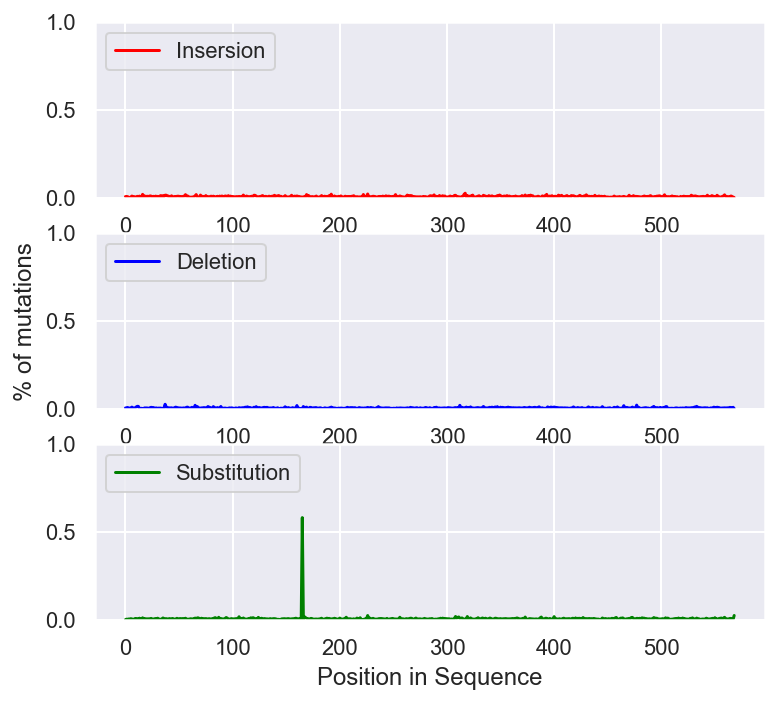

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

fig = plt.figure(figsize = (6,5.5))
#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す
ax1.plot(dists_ins, color="red", label="Insersion")
ax2.plot(dists_del, color="blue", label="Deletion")
ax3.plot(dists_sub, color="green", label="Substitution")

ax2.set_ylabel("% of mutations")
ax3.set_xlabel("Position in Sequence")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# 凡例表示
ax1.legend(loc = 'upper left') 
ax2.legend(loc = 'upper left') 
ax3.legend(loc = 'upper left') 

plt.show()

In [159]:
def get_sequence_error(x, x_subset, threshold):
    avg = np.average(x)
    var = np.var(x)
    scores = [(xi - avg) ** 2 / var for xi in x_subset]
    th = stats.chi2.interval(1 - threshold, 1)[1]
    return scores

In [160]:
x = dists_ins + dists_del + dists_sub

In [162]:
y = get_sequence_error(x, dists_ins, 0.05)
print(y[:10])

[0.0010540335398255445, 0.05512080530981595, 0.00011940523453021248, 0.13026711722246878, 0.13026711722246878, 0.014678978223722916, 0.04443541248423352, 0.00023214569438355405, 1.182846261309051e-05, 0.03194142813298815]


In [93]:
print(y[i_pm//5: i_pm//5+10])
print(sum(y))

[False, True, True, True, True, True, True, True, True, True]
568


## 既存の関数`extract_sequence_errors`と出力フォーマットを合わせる

In [189]:
def old_extract_sequence_errors(count_5mer_sample, count_5mer_control, coverage_sample, coverage_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    for mutation in ["ins", "del", "sub"]:
        for i in range(len(sequence_errors)):
            samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
            cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
            cossim = 1 - distance.cosine(samp, cont)
            _, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
            if cossim > 0.9 or pvalue > 0.05:
                sequence_errors[i].add(mutation)
    return sequence_errors

In [190]:
before = old_extract_sequence_errors(count_5mer_sample, count_5mer_control, coverage_sample, coverage_control)
print(before[34])

{'del', 'ins', 'sub'}


In [196]:
mutation = "sub"
i = 165
print(count_5mer_sample[i][mutation])
print(count_5mer_control[i][mutation])
samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
cossim = 1 - distance.cosine(samp, cont)
_, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
print(cossim, pvalue)
print(samp, cont)

[1, 1, 1, 81, 1]
[1, 1, 1, 1, 1]
0.4691552259617495 0.37386602157636706
[0.00010867202782003912, 0.00010867202782003912, 0.00010867202782003912, 0.00880243425342317, 0.00010867202782003912] [0.00010853049706967658, 0.00010853049706967658, 0.00010853049706967658, 0.00010853049706967658, 0.00010853049706967658]


In [205]:
x = np.array(samp)*10000
y = np.array(cont)*10000
_, pvalue = stats.ttest_ind(x, y, equal_var=False)
print(pvalue, x, y)

0.3738660215763667 [ 1.08672028  1.08672028  1.08672028 88.02434253  1.08672028] [1.08530497 1.08530497 1.08530497 1.08530497 1.08530497]


In [259]:
def extract_sequence_errors(count_5mer_sample, count_5mer_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    dists = defaultdict(list)
    # Calculate Jensen-Shannon distance
    for samp,cont in zip(count_5mer_sample, count_5mer_control):
        for mutation in ["ins", "del", "sub"]:
            s = samp[mutation]
            c = cont[mutation]
            dists[mutation].append(distance.jensenshannon(s, c))
    # Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
    dists_all = np.array(list(dists.values())).flatten()
    avg = np.average(dists_all[~np.isnan(dists_all)])
    var = np.var(dists_all[~np.isnan(dists_all)])
    threshold = 0.05
    for mutation in ["ins", "del", "sub"]:
        dists_subset = dists[mutation]
        scores = [(xi - avg) ** 2 / var for xi in dists_subset]
        thres = stats.chi2.interval(1 - threshold, 1)[1]
        for i, score in enumerate(scores):
            # 'nan' means the two distributions have too different, so it could be a real mutation
            if np.isnan(score):
                continue
            if score < thres:
                sequence_errors[i].add(mutation)
    return sequence_errors

In [260]:
x = extract_sequence_errors(count_5mer_sample, count_5mer_control)
print(x[:10])
print(before == x)
# print(x.keys())
# print(np.array(list(x.values())).flatten())
# print(len(x["ins"]))

[{'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}, {'del', 'ins', 'sub'}]
False


In [261]:
print(len(before), len(x))
for i, (a, b) in enumerate(zip(before, x)):
    if a != b:
        print(i, a, b)

569 569
165 {'del', 'ins', 'sub'} {'del', 'ins'}


In [242]:
mutation = "del"
i = 64
mutation = "sub"
i = 165
print(count_5mer_sample[i][mutation])
print(count_5mer_control[i][mutation])
samp = [c / coverage_sample for c in count_5mer_sample[i][mutation]]
cont = [c / coverage_control for c in count_5mer_control[i][mutation]]
cossim = 1 - distance.cosine(samp, cont)
_, pvalue = stats.ttest_ind(samp, cont, equal_var=False)
dist = distance.euclidean(samp, cont)
print(cossim, pvalue, dist)
print(samp, cont)

[1, 1, 1, 81, 1]
[1, 1, 1, 1, 1]
0.4691552259617495 0.37386602157636706 0.00869390376096154
[0.00010867202782003912, 0.00010867202782003912, 0.00010867202782003912, 0.00880243425342317, 0.00010867202782003912] [0.00010853049706967658, 0.00010853049706967658, 0.00010853049706967658, 0.00010853049706967658, 0.00010853049706967658]


0.0
0.5
1.0
5.0
5.5
6.0
10.0
10.5
11.0


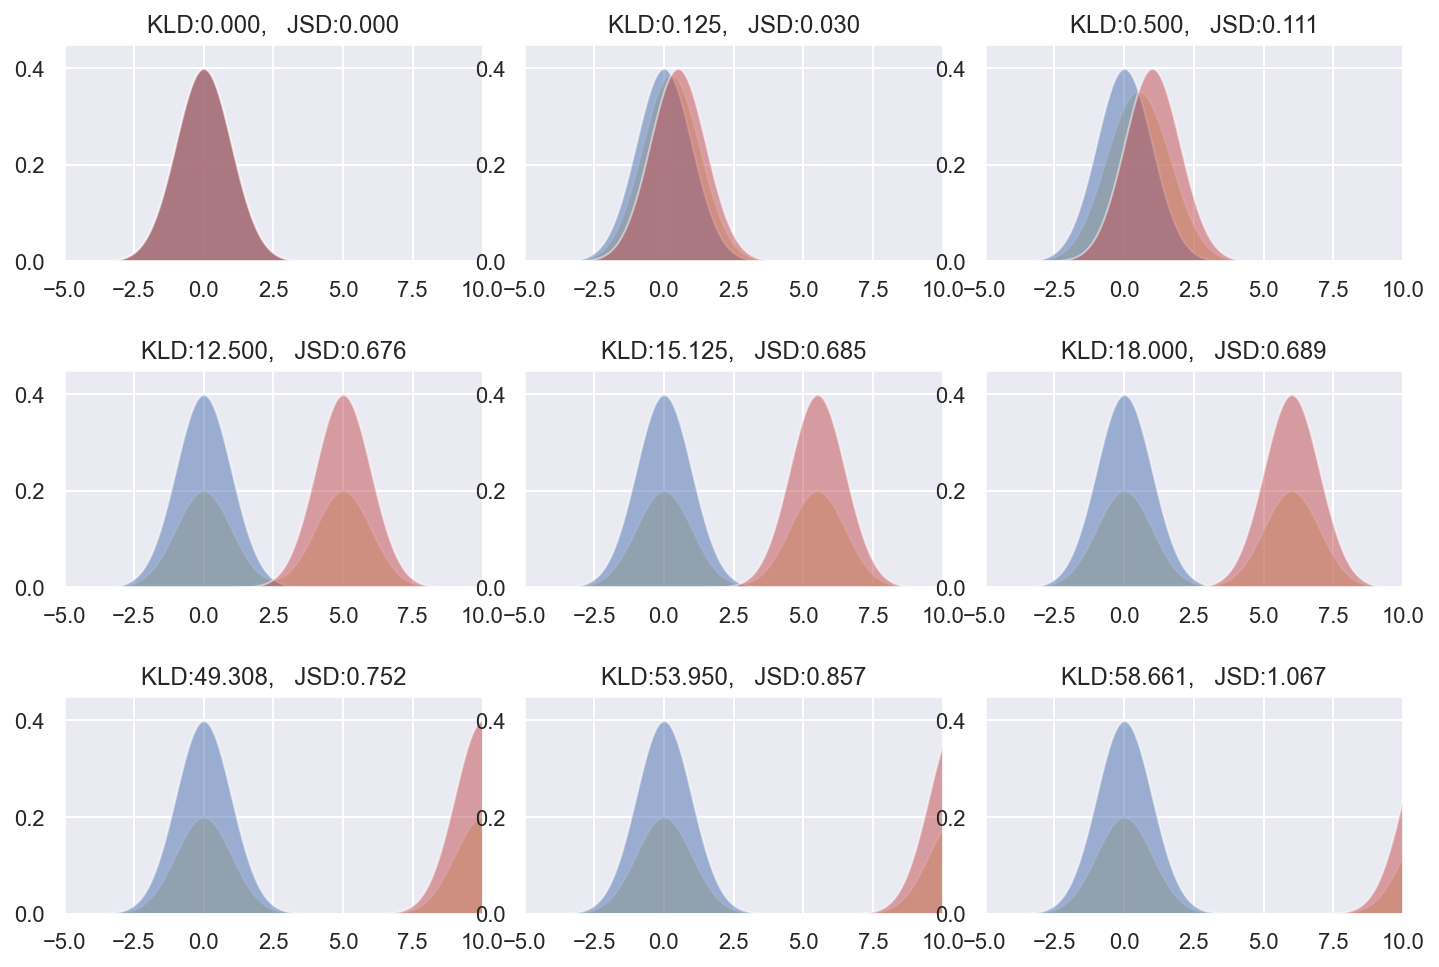

In [255]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, entropy

x = np.linspace(-10.0, 10.0, 10000)

# 図形サイズ
plt.figure(figsize=(12,8))

# 3x3のsubplot
for i in np.arange(3):
    for j in np.arange(3):

        index = i*10 + j

        # 各確率分布を定義
        p = norm.pdf(x, loc=0, scale=1)
        q = norm.pdf(x, loc=index*0.5, scale=1)
        print(index*0.5)
        # pとqの平均の確率分布
        m = (p+q)/2
        # KL divergenceとJS divergenceの計算
        kl = entropy(p, q)
        kl_pm = entropy(p, m)
        kl_qm = entropy(q, m)
        js = (kl_pm + kl_qm)/2

        # subplot
        plt.subplot(3,3,i*3+j+1)
        # 図形塗りつぶし
        plt.fill_between(x, m, facecolor="y", alpha=0.5)
        plt.fill_between(x, p, facecolor="b", alpha=0.5)
        plt.fill_between(x, q, facecolor="r", alpha=0.5)
        # 以下は整形
        plt.xlim(-5, 10)
        plt.ylim(0,0.45)
        plt.title("KLD:{:>.3f}".format(kl) + ",   JSD:{:>.3f}".format(js))
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

In [238]:
x = np.array([pow(2,10),1,2,3], dtype=np.uint64)

array([1024,    1,    2,    3], dtype=uint64)

## 改定した`extract_sequence_errors`でtest

In [263]:
%%bash
rm -rf "DAJINResults/.tempdir"
ls DAJINResults

In [264]:
%%bash
# Tyr 01%
time python misc/quickstart.py

processing test-tyr-albino-01%...



real	6m17.645s
user	8m5.423s
sys	2m28.598s


In [265]:
%%bash
# knockout
time python misc/quickstart.py

processing test-knockout...



real	5m11.409s
user	5m33.800s
sys	0m59.100s


In [266]:
%%bash
# ayabe-task1
time python misc/quickstart.py

processing test-ayabe-task1...



real	1m27.458s
user	2m16.130s
sys	1m34.636s


# 結果


+ 距離の定義を`distance.jensenshannon`に変更しても、ほぼ問題なく遺伝型解析ができた
+ Flox insertionのアレル6のC->T変異は**クオリティが低いのでこれもシークエンスエラーの可能性が高い**
    + `chr2:180,263,117-180,263,146`


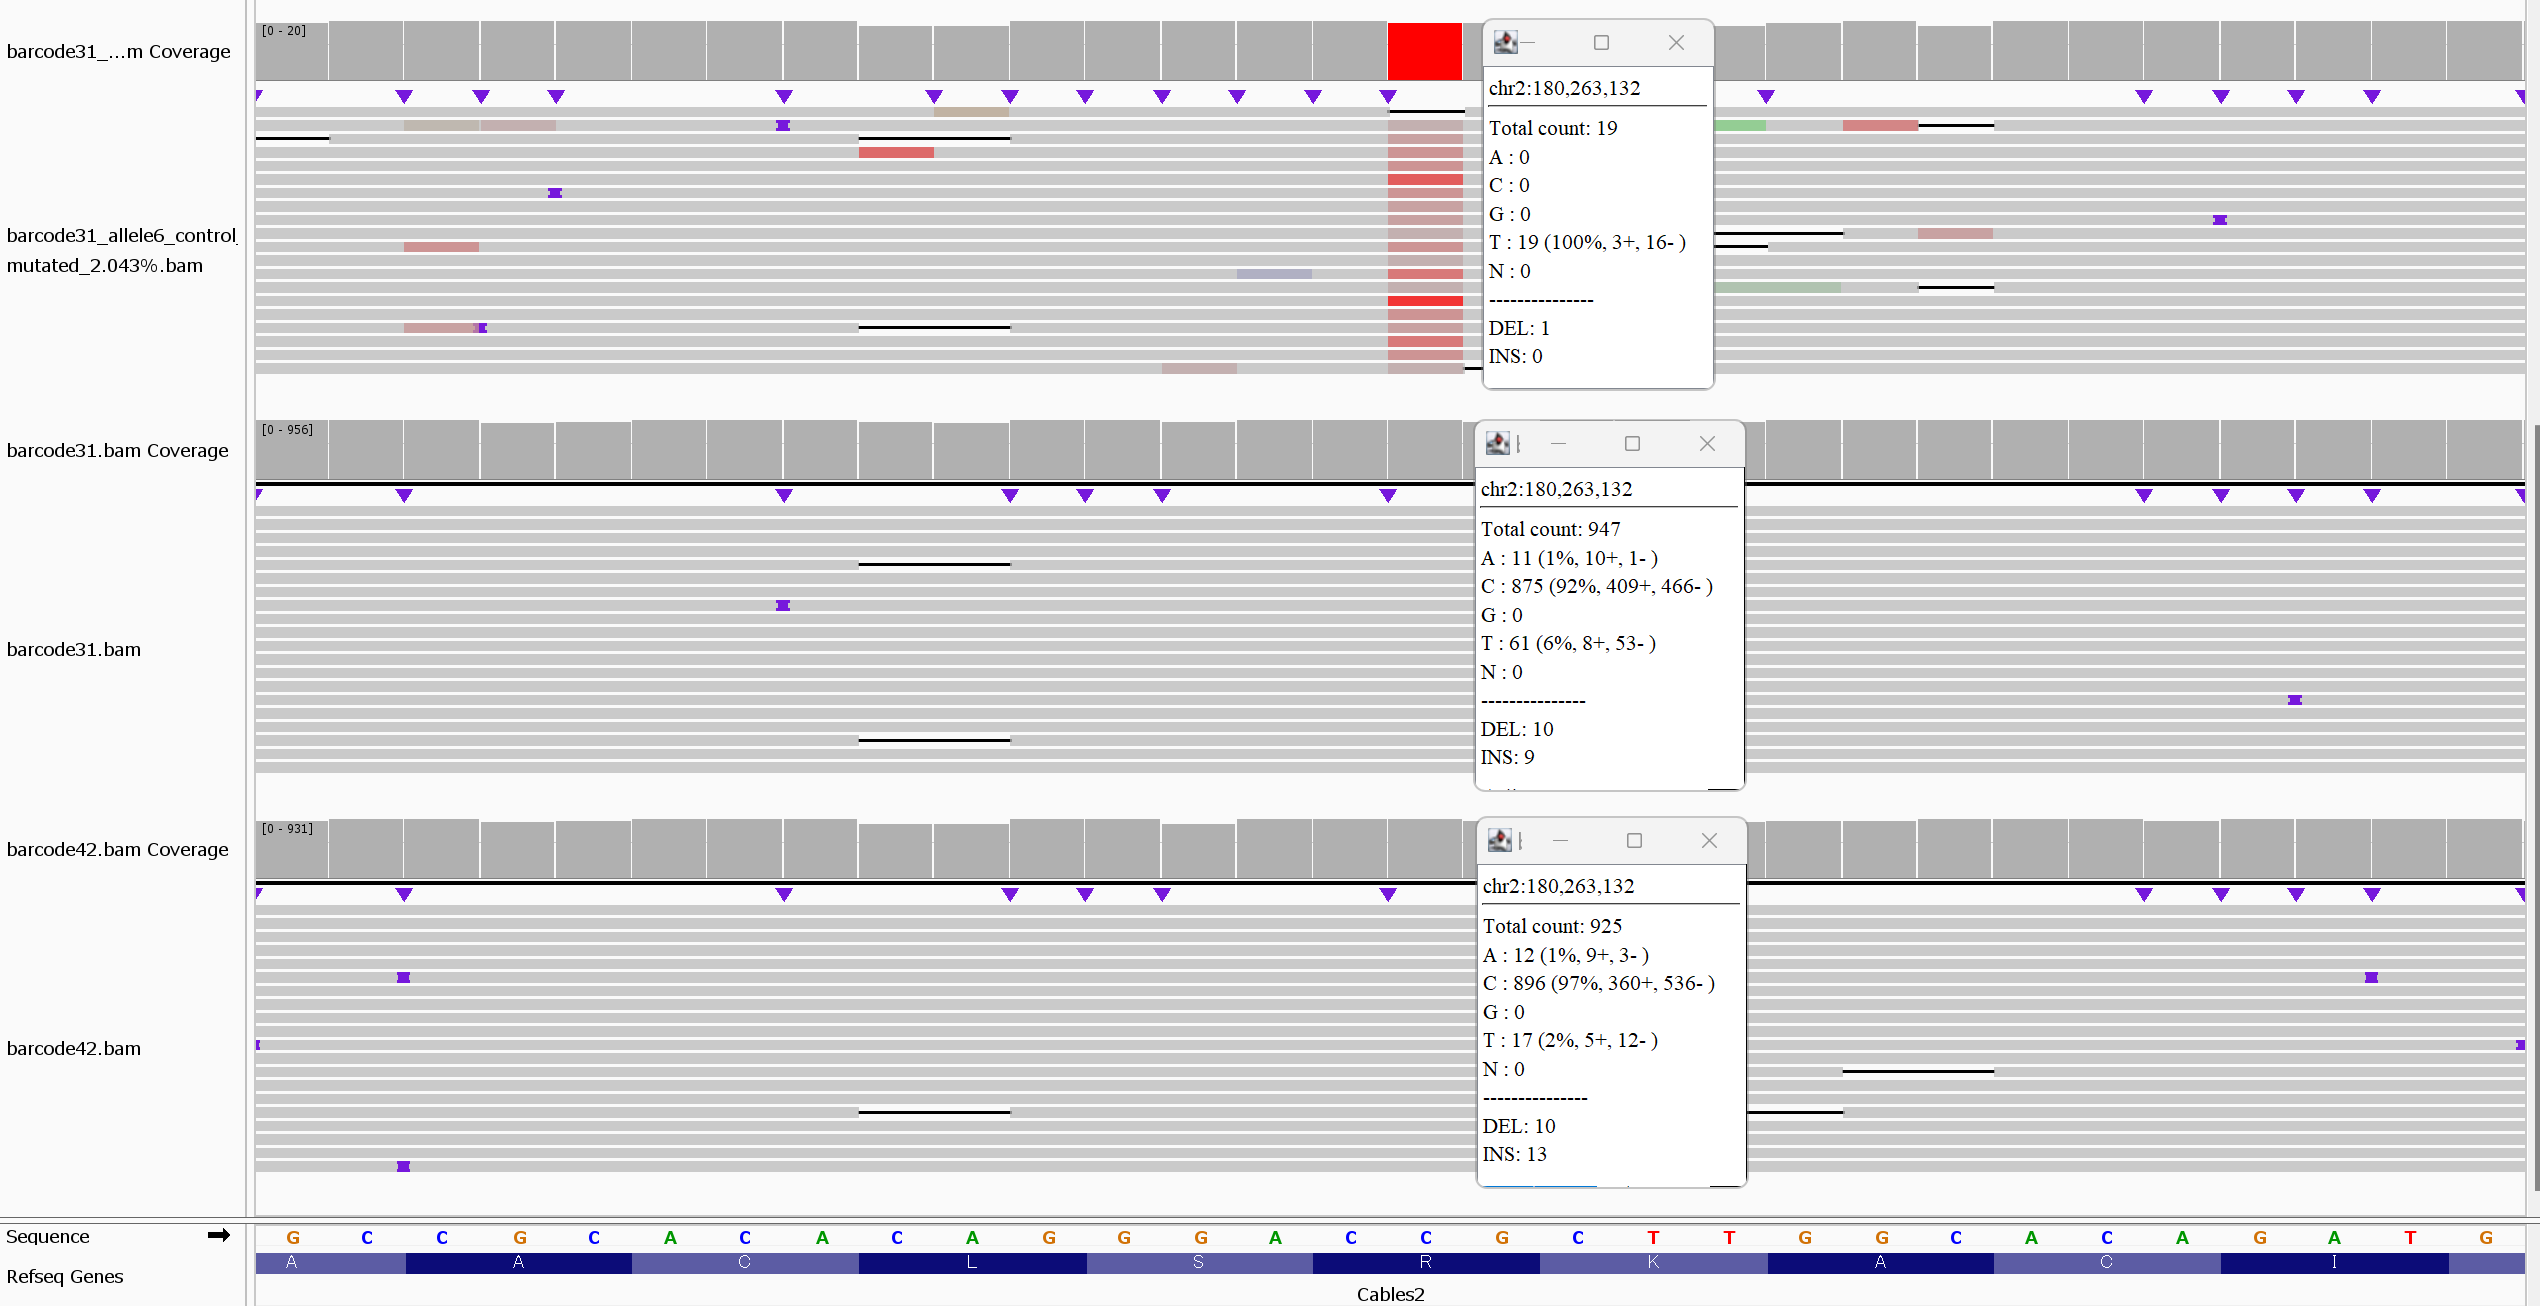

# 次回の課題

+ [x] ~~点変異、欠失、ノックインのデザインで動くかを確認する~~
+ [x] ~~Clusteringのときの警告メッセージは無害なので消去する~~
+ [ ] right_loxpがいまいちな理由を考察する
    +  ~~[x] Ayabe-task1のpreprocessにおいて、329と1280の補正がされていない理由を検討する~~ -> distanceの閾値を下げた -> distanceの定義を変えた
+ [x] ~~distanceの閾値を下げた状態で、1%点変異が検出できるか~~
+ [ ] Flox insertionのアレル6のC->T変異は**クオリティが低いのでこれもシークエンスエラーの可能性が高い** (`20230215-distance-cosine.ipynb`)
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか
    + JS距離で抽出された変異部位だけを標的とする？
    + 両端のNを気にする必要がなくなる